### Dependencies

In [204]:
# dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor # our model of choice
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna # hyperparameter tuning

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dummy ts data

In [12]:
# code to create dummy seasonal and trend data
date_rng = pd.date_range(start='2018-01-01', periods=60, freq='MS')
trend = np.arange(len(date_rng)) * 2
seasonal_period = 12 
seasonality = 20 * np.sin(2 * np.pi * np.arange(len(date_rng)) / seasonal_period)
data = trend + seasonality + np.random.normal(scale=5, size=len(date_rng))
df = pd.DataFrame(data={'month': date_rng, 'demand': data})

### Plotting

Text(0.5, 1.0, 'Demand month vs. quantity')

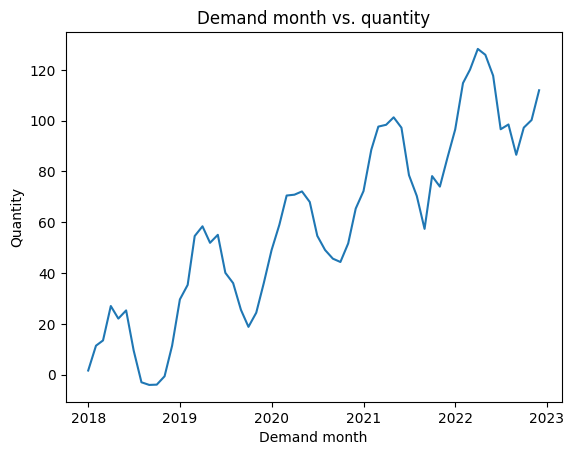

In [13]:
plt.plot(df['month'],df['demand'])
plt.xlabel('Demand month')
plt.ylabel('Quantity')
plt.title('Demand month vs. quantity')

### Lagging data

In [72]:
def lag_df(df, lags):
    new_df = df.copy()
    cols = ['demand_l' + str(i + 1) for i in range(lags)]
    for i in range(1, len(cols) + 1):
        new_df[cols[i-1]] = new_df['demand'].shift(i)

    new_df = new_df.dropna()

    return new_df

In [157]:
def lag_df_non_sequential(df, lag_set):
    new_df = df.copy()
    cols = ['demand_l' + str(i) for i in lag_set]
    for i in range(1, len(cols) + 1):
        new_df[cols[i-1]] = new_df['demand'].shift(i)

    new_df = new_df.dropna()
    return new_df

In [174]:
def lag_single(df, lag):
    new_df = df.copy()
    new_df['demand_l' + str(lag)] = new_df['demand'].shift(lag)
    new_df = new_df.dropna()

    return new_df
    

### Model

In [207]:
def run_XGB(df):
    lags = df.drop(['month', 'demand'], axis=1).columns
    
    X_train, X_test, y_train, y_test = train_test_split(df[lags], df['demand'], test_size=.25, shuffle=False)
    
    def objective(trial):
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
            'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 9),
            'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 0.95, 0.05),
            'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.6, 0.95, 0.05),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100)
        }

        model = XGBRegressor(**params)
        model.fit(X_train,y_train)
        y_test_preds = model.predict(X_test)

        error = mean_squared_error(y_test_preds, y_test)

        return error
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=30)

    model = XGBRegressor(**study.best_params)
    model.fit(X_train, y_train)
    
    y_test_preds = model.predict(X_test)
    error = mean_squared_error(y_test, y_test_preds)
    
    demand_frame = pd.DataFrame({
        'month':df['month'],
        'demand':df['demand']
    })
    forecast_frame = pd.DataFrame({
        'month': df['month'].iloc[-X_test.shape[0]:],
        'demand':y_test_preds
    })

    return demand_frame, forecast_frame

In [200]:
df_1 = lag_df(df,6)
df_2 = lag_df_non_sequential(df, [6,12])
df_3 = lag_single(df, 5)

In [208]:
demand, forecast = run_XGB(df_1)

[I 2024-07-18 21:41:21,368] A new study created in memory with name: no-name-31b912b4-e450-4ba8-a16a-25870de036e3
/var/folders/k_/y5wzmsx1483f9z9t9tjtdj1m0000gn/T/ipykernel_3478/964608366.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
/var/folders/k_/y5wzmsx1483f9z9t9tjtdj1m0000gn/T/ipykernel_3478/964608366.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
/var/folders/k_/y5wzmsx1483f9z9t9tjtdj1m0000gn/T/ipykernel_3478/964608366.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

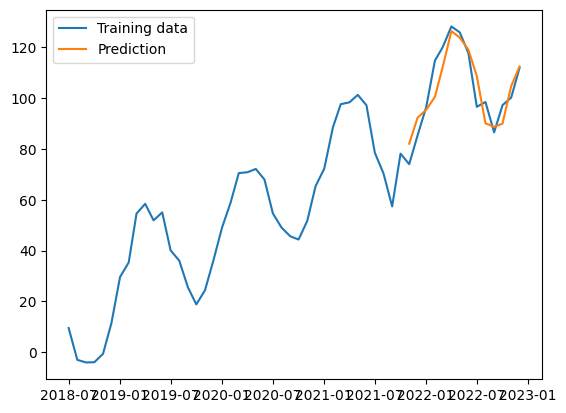

In [210]:
plt.plot(demand['month'], demand['demand'])
plt.plot(forecast['month'], forecast['demand'])
plt.legend(['Training data', 'Prediction'])